In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from datetime import datetime, timedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler

c:\study\class2021s\dsmldl\mlpythonproject\venv\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
class IndexMaker:
    """How to make indices manually"""
    """If one want to use module, possible to use TA-Lib for example"""
    """https://mrjbq7.github.io/ta-lib/"""
    
    def __init__(self, sample):
        self.sample = sample.copy()
    
    def ohlc(self):
        ohlc = self.sample[['Open', 'High', 'Low', 'Close']]
        ohlc['number'] = ohlc.index.map(mdates.date2num)
        return ohlc[['number', 'Open', 'High', 'Low', 'Close']]
    
    def moving_avg(self, days):
        ma = self.sample[['Close']].copy()
        ma['MA'+str(days)] = ma.Close.rolling(window=days).mean()
        ma['number'] = ma.index.map(mdates.date2num)
        return ma[['number', 'MA'+str(days)]]
    
    def exp_moving_avg(self, days):
        ema = self.sample[['Close']].copy()
        ema['EMA'+str(days)] = ema.Close.ewm(span=days).mean()
        ema['number'] = ema.index.map(mdates.date2num)
        return ema[['number', 'EMA'+str(days)]]
    
    def bollinger_band(self, days=20):
        bb = self.sample[['Close']].copy()
        bb['Center'] = bb.Close.rolling(window=days).mean()
        bb['Upper'] = bb.Center + 2.*bb.Close.rolling(window=days).std()
        bb['Lower'] = bb.Center - 2.*bb.Close.rolling(window=days).std()
        bb['PercentB'] = (bb.Close - bb.Lower)/(bb.Upper - bb.Lower)
        bb['number'] = bb.index.map(mdates.date2num)
        return bb[['number', 'Center', 'Upper', 'Lower', 'PercentB']]
    
    def RSI(self, days):
        rsi = self.sample[['Close']].copy()
        rsi['U'] = 0.
        rsi['D'] = 0.
        for date in rsi.index:
            if rsi.loc[date, 'Close'] > rsi.shift(1).loc[date, 'Close']:
                rsi.loc[date, 'U'] = rsi.loc[date, 'Close'] - rsi.shift(1).loc[date, 'Close']
                rsi.loc[date, 'D'] = 0.
            else:
                rsi.loc[date, 'D'] = rsi.shift(1).loc[date, 'Close'] - rsi.loc[date, 'Close']
                rsi.loc[date, 'U'] = 0.
        rsi['AU'] = rsi['U'].rolling(window=days).mean()
        rsi['AD'] = rsi['D'].rolling(window=days).mean()
        rsi['RSI'] = rsi['AU']/(rsi['AU']+rsi['AD'])
        rsi['number'] = rsi.index.map(mdates.date2num)
        return rsi[['number', 'AU', 'AD', 'RSI']]

    def MFI(self, days):
        mfi = self.sample[['High', 'Low', 'Close', 'Volume']].copy()
        mfi['TP'] = (mfi['High'] + mfi['Low'] + mfi['Close'])/3
        mfi['PMF'] = 0.
        mfi['NMF'] = 0.
        for date in mfi.index:
            if mfi.loc[date, 'TP'] > mfi.shift(1).loc[date, 'TP']:
                mfi.loc[date, 'PMF'] = mfi.loc[date, 'TP']*mfi.loc[date, 'Volume']
                mfi.loc[date, 'NMF'] = 0.
            else:
                mfi.loc[date, 'NMF'] = mfi.loc[date, 'TP']*mfi.loc[date, 'Volume']
                mfi.loc[date, 'PMF'] = 0.
        mfi['MFI'] = mfi.PMF.rolling(window=days).sum()/(mfi.PMF.rolling(window=days).sum()+mfi.NMF.rolling(window=days).sum())
        mfi['number'] = mfi.index.map(mdates.date2num)
        return mfi[['number', 'TP', 'PMF', 'NMF', 'MFI']]
    
    def macd(self):
        ema60 = self.exp_moving_avg(days=60)
        ema130 = self.exp_moving_avg(days=130)
        macd = self.sample[['Close']].copy()
        macd['MACD'] = ema130['EMA130'] - ema60['EMA60']
        macd['signal'] = macd['MACD'].ewm(span=45).mean()
        macd['MACDHist'] = macd["MACD"] - macd['signal']
        macd['number'] = macd.index.map(mdates.date2num)
        return macd[['number', 'MACD', 'signal', 'MACDHist']]

    def oscillator(self, days=14):
        oscillator = self.sample[['Open', 'High', 'Low', 'Close']].copy()
        ndays_high = oscillator.High.rolling(window=days).max()
        ndays_low = oscillator.Low.rolling(window=days).min()
        oscillator['fast_k'] = (oscillator.Close - ndays_low)/(ndays_high - ndays_low)
        oscillator['slow_d'] = oscillator.fast_k.rolling(window=3).mean()
        oscillator['number'] = oscillator.index.map(mdates.date2num)
        return oscillator[['number', 'fast_k', 'slow_d']]


In [5]:
# get sample
df = pd.read_csv("./coin_Bitcoin.csv")
df = df[['Date', 'High', 'Low', 'Open', 'Close', 'Volume']]
for idx in df.index:
    if df.loc[idx, 'Volume'] == 0.:
        df.loc[idx, 'Volume'] = np.nan
    date_time = df.loc[idx, 'Date'].split(" ")
    date, time = date_time[0], date_time[1]
    df.loc[idx, 'Date'] = datetime.strptime(date, '%Y-%m-%d').date()
df = df.set_index('Date')
df = df.dropna()

In [6]:
# make indices
# note that some indices may not exist for the first few days(or month)
# because they are generated from the past
# Recommend to use cushion data or use df.dropna()

start_date = datetime.strptime('2017-01-01', '%Y-%m-%d').date()
#end_date = datetime.strptime('2021-02-27', '%Y-%m-%d').date()
maker = IndexMaker(df)
ohlc = maker.ohlc().loc[start_date:, :]
ma200 = maker.moving_avg(days=200).loc[start_date:, :]
ema130 = maker.exp_moving_avg(days=130).loc[start_date:, :]
bollinger20 = maker.bollinger_band(days=20).loc[start_date:, :]
mfi14 = maker.MFI(days=14).loc[start_date:, :]
rsi14 = maker.RSI(days=14).loc[start_date:, :]
macd = maker.macd().loc[start_date:, :]
oscillator = maker.oscillator().loc[start_date:, :]

In [7]:
# target 
from datetime import timedelta
second_date = start_date + timedelta(days=1)
tommorow_Close = ohlc.Close[second_date:]
dateindex = tommorow_Close.index- timedelta(days=1)
tommorow_Close.index = dateindex
tommorow_Open = ohlc.Open[second_date:]
tommorow_Open.index = dateindex 
tommorow_IncRatio = tommorow_Close/tommorow_Open
tommorow_Positive = (tommorow_Close>tommorow_Open).astype(int)

### Feature & Target

feature : o, h, l, c, Volume, MA200, EMA130, PercentB20, RSI14, MFI14, MACD, fast_k, slow_d <p>
target : tommorow_Close, tommorow_positive 

In [8]:
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2020-12-31', '%Y-%m-%d').date()
eve_date = end_date - timedelta(days=1)
Full_df = df
Full_df['MA200'] = ma200.MA200
Full_df['EMA130']=ema130.EMA130
Full_df['PercentB20']=bollinger20.PercentB
Full_df['RSI14']= rsi14.RSI
Full_df['MFI14']= mfi14.MFI
Full_df['MACD']= macd.MACD
Full_df['fast_k'] = oscillator.fast_k
Full_df['slow_d'] = oscillator.slow_d
Full_df['Tommorow_Close']= tommorow_Close
Full_df['Tommorow_IncRatio']= tommorow_IncRatio
Full_df['Tommorow_Pos']= tommorow_Positive 
Full_df = Full_df[start_date: eve_date]

In [9]:
Full_df

,High,Low,Open,Close,Volume,MA200,EMA130,PercentB20,RSI14,MFI14,MACD,fast_k,slow_d,Tommorow_Close,Tommorow_IncRatio,Tommorow_Pos
Date,,,,,,,,,,,,,,,,
2017-01-01,1003.080017,958.698975,963.658020,998.325012,1.477750e+08,676.439377,726.854930,0.896990,0.859802,0.789506,-73.609344,0.977651,0.934168,1021.750000,1.023165,1.0
2017-01-02,1031.390015,996.702026,998.617004,1021.750000,2.221850e+08,677.716587,731.357145,0.913535,0.869408,0.805343,-76.362399,0.959815,0.951889,1043.839966,1.021770,1.0
2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,1.851680e+08,679.191241,736.127876,0.921943,0.875023,0.814751,-79.333322,0.999019,0.978828,1154.729980,1.105640,1.0
2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,3.449460e+08,681.183756,742.518748,1.098171,0.899147,0.833259,-84.066016,0.985581,0.981472,1013.380005,0.876073,0.0
2017-01-05,1191.099976,910.416992,1156.729980,1013.380005,5.101990e+08,682.431751,746.654034,0.722185,0.645207,0.673515,-86.055164,0.459285,0.814628,902.200989,0.889534,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,26718.070893,24522.689482,24677.016056,26437.037509,4.833265e+10,12929.903141,15766.746562,0.976863,0.851761,0.920118,-2997.597949,0.964799,0.962039,26272.294567,0.993681,0.0
2020-12-27,28288.840022,25922.769765,26439.373289,26272.294567,6.647990e+10,13011.914142,15927.136608,0.903582,0.833914,0.927265,-3083.370200,0.782609,0.913536,27084.807886,1.030592,1.0
2020-12-28,27389.112064,26207.639931,26280.821415,27084.807886,4.905674e+10,13100.729275,16097.482734,0.919669,0.844247,0.931462,-3177.755257,0.869255,0.872221,27362.436557,1.010362,1.0


In [10]:
cut_date = datetime.strptime('2019-12-31', '%Y-%m-%d').date()
train_df = Full_df[start_date: cut_date]
test_df = Full_df[(cut_date + timedelta(days=1)):eve_date]
print("size of train set : ", len(train_df), "  |  size of test set : ", len(test_df))                                          

size of train set :  1095   |  size of test set :  365


In [11]:
X_train = train_df.drop(['Tommorow_Close','Tommorow_IncRatio','Tommorow_Pos'],axis='columns')
X_test = test_df.drop(['Tommorow_Close','Tommorow_IncRatio','Tommorow_Pos'],axis='columns')

## Random forest (Regression)

#### feature : o, h, l, c, Volume, MA200, EMA130, PercentB20, RSI14, MFI14, MACD, fast_k, slow_d 
#### target : tommorow_Close

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

In [13]:
y_train = train_df.loc[:,'Tommorow_Close']
y_test = test_df.loc[:,'Tommorow_Close']

In [14]:
# define random forest regressor
rfc0 = RandomForestRegressor(n_estimators=200, max_depth= 40 , random_state=0)
rfc0.fit(X_train,y_train)
y_pred = rfc0.predict(X_test)
mae_loss_rf0= mean_absolute_error(y_test, y_pred)
print("mae loss of random forest with all feature, 200 tress, 40 depth :  %.2f" % mae_loss_rf0)

mae loss of random forest with all feature, 200 tress, 40 depth :  768.45


In [15]:
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

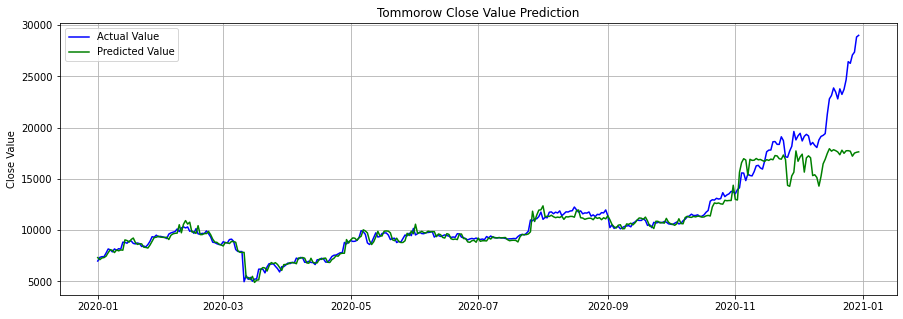

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index,y_test,'b', label="Actual Value")
plt.plot(y_pred.index, y_pred, 'g', label='Predicted Value')
plt.ylabel('Close Value')
plt.title("Tommorow Close Value Prediction")

plt.grid(True)
plt.legend(loc='best')

plt.show()


#### target : tommorow_IncRatio

In [17]:
y_train = train_df.loc[:,'Tommorow_IncRatio']
y_test = test_df.loc[:,'Tommorow_IncRatio']

In [18]:
# define random forest regressor
rfc1 = RandomForestRegressor(n_estimators=200, max_depth= 40 , random_state=0)
rfc1.fit(X_train,y_train)
y_pred = rfc1.predict(X_test)
mae_loss_rf1= mean_absolute_error(y_test, y_pred)
print("mae loss of random forest with all feature, 200 tress, 40 depth :  %.2f" % mae_loss_rf1)

mae loss of random forest with all feature, 200 tress, 40 depth :  0.03


In [19]:
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

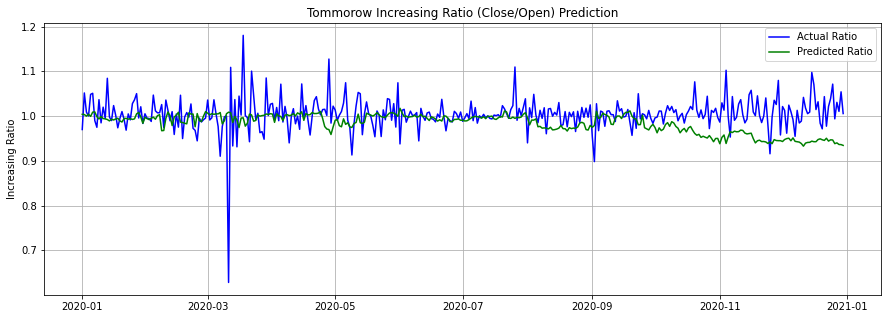

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index,y_test,'b', label="Actual Ratio")
plt.plot(y_pred.index, y_pred, 'g', label='Predicted Ratio')
plt.ylabel('Increasing Ratio')
plt.title("Tommorow Increasing Ratio (Close/Open) Prediction")

plt.grid(True)
plt.legend(loc='best')

plt.show()

## Random forest (Classification)
feature : o, h, l, c, Volume, MA200, EMA130, PercentB20, RSI14, MFI14, MACD, fast_k, slow_d <p>
target : tommorow_pos

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [22]:
y_train = train_df.loc[:,'Tommorow_Pos']
y_test = test_df.loc[:,'Tommorow_Pos']

In [23]:
# define random forest regressor
rfc2 = RandomForestClassifier(n_estimators=200, max_depth= 40 , random_state=0)
rfc2.fit(X_train,y_train)
y_pred = rfc2.predict(X_test)
accuracy_rf2= accuracy_score(y_test, y_pred)
print("accuracy of random forest with all feature, 200 tress, 40 depth :  %.2f" % accuracy_rf2)

accuracy of random forest with all feature, 200 tress, 40 depth :  0.47


In [24]:
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[121,  37],
       [155,  52]], dtype=int64)

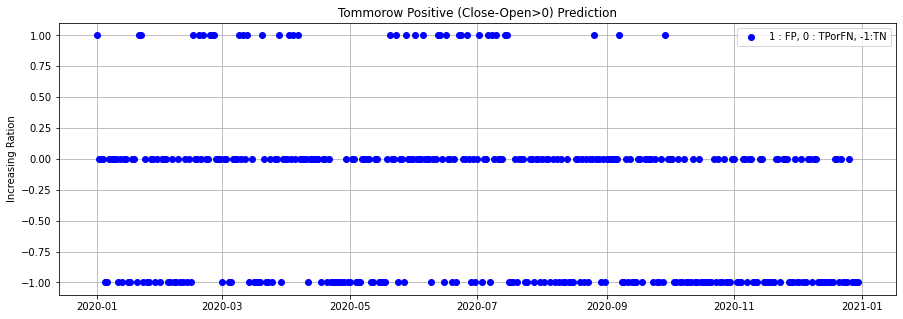

In [25]:
y_error = y_pred - y_test 
plt.figure(figsize=(15, 5))
plt.plot(y_error.index,y_error ,'bo', label="1 : FP, 0 : TPorFN, -1:TN")
# FP = False(actual)-Positive(pred), TP=True-Postive, FN=False-Negative, TN=True-Negative
plt.ylabel('Increasing Ration')
plt.title("Tommorow Positive (Close-Open>0) Prediction")

plt.grid(True)
plt.legend(loc='best')

plt.show()